## Import Packages and fix seed

In [50]:
import pandas as pd
import random
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# seed 고정
rand_seed = 3100
seed_everything(rand_seed)

## Load Data

In [16]:
import os
os.chdir('C:\\Users\\SGC\\Desktop\\Zenryoku')

In [17]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')
sample_submission = pd.read_csv('./sample_submission.csv')

## Simple info

In [19]:
train_df.head()

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [22]:
train_df.describe()

,건물번호,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
count,204000.000000,204000.000000,43931.000000,203981.000000,203991.000000,128818.000000,116087.000000,204000.000000
mean,50.500000,25.543524,2.040830,2.134031,78.716295,0.333637,1.063823,2451.036462
std,28.866141,3.779523,5.165218,1.358109,15.080108,0.401486,1.001030,2440.648858
min,1.000000,10.100000,0.000000,0.000000,13.000000,0.000000,0.000000,0.000000
25%,25.750000,23.400000,0.000000,1.200000,69.000000,0.000000,0.200000,1085.760000
50%,50.500000,25.700000,0.100000,2.000000,81.000000,0.100000,0.710000,1766.400000
75%,75.250000,28.100000,1.300000,2.800000,91.000000,0.700000,1.780000,2970.000000
max,100.000000,37.100000,92.200000,13.300000,100.000000,1.000000,3.920000,25488.400000


In [24]:
train_df.shape

(204000, 10)

In [26]:
# 결측치 존재 여부를 확인해주는 함수
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if counted_missing_col == 0:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train_df)

결측치가 있는 컬럼은: 강수량(mm)입니다
해당 컬럼에 총 160069개의 결측치가 존재합니다.
결측치가 있는 컬럼은: 풍속(m/s)입니다
해당 컬럼에 총 19개의 결측치가 존재합니다.
결측치가 있는 컬럼은: 습도(%)입니다
해당 컬럼에 총 9개의 결측치가 존재합니다.
결측치가 있는 컬럼은: 일조(hr)입니다
해당 컬럼에 총 75182개의 결측치가 존재합니다.
결측치가 있는 컬럼은: 일사(MJ/m2)입니다
해당 컬럼에 총 87913개의 결측치가 존재합니다.


In [67]:
def plot_histogram(dataframe):
    # Select numeric columns
    numeric_cols = dataframe.select_dtypes(include=[np.number]).columns.tolist()

    # Set the number of graphs in the grid
    if len(numeric_cols) % 2 == 0:
        subplot_x = 4
        subplot_y = len(numeric_cols) // 2
    else:
        subplot_x = 4
        subplot_y = len(numeric_cols) // 2 + 1

    # Set the overall size of the grid
    plt.figure(figsize=(15, subplot_y * 3))  # Adjust the size here

    # Loop through numeric columns and add subplot for each
    for idx, col in enumerate(numeric_cols, 1):
        plt.subplot(subplot_y, subplot_x, idx)
        plt.hist(dataframe[col].dropna(), bins=30, color='skyblue', edgecolor='black') # Exclude missing values
        plt.title(f'Histogram of {col}')
    
    plt.tight_layout()
    plt.show()


In [71]:
import matplotlib.font_manager as fm
font_path = 'C:\\Windows\\Fonts\\batang.ttc'
font_prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_prop.get_name())

In [72]:
import matplotlib.font_manager
print(matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf'))


['C:\\Windows\\Fonts\\LFAXI.TTF', 'C:\\Windows\\Fonts\\PAPYRUS.TTF', 'C:\\Users\\SGC\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumSquareOTF_acL.otf', 'C:\\Windows\\Fonts\\BOD_BLAI.TTF', 'C:\\Windows\\Fonts\\AdobeFangsongStd-Regular.otf', 'C:\\Windows\\Fonts\\TCM_____.TTF', 'C:\\Windows\\Fonts\\OpenSans-Semibold.ttf', 'C:\\Windows\\Fonts\\SansSerifCollection.ttf', 'C:\\Windows\\Fonts\\verdanaz.ttf', 'C:\\Users\\SGC\\AppData\\Local\\Microsoft\\Windows\\Fonts\\강원교육모두+Bold.ttf', 'C:\\Windows\\Fonts\\CascadiaMono.ttf', 'C:\\Windows\\Fonts\\ACaslonPro-Bold.otf', 'C:\\Windows\\Fonts\\batang.ttc', 'C:\\Windows\\Fonts\\segoeuib.ttf', 'C:\\Windows\\Fonts\\HANBatangExtBB.ttf', 'C:\\Windows\\Fonts\\H2SA1M.TTF', 'C:\\Windows\\Fonts\\GILLUBCD.TTF', 'C:\\Windows\\Fonts\\REFSPCL.TTF', 'C:\\Windows\\Fonts\\Hancom HMJE_V.ttf', 'C:\\Windows\\Fonts\\BOOKOSB.TTF', 'C:\\Windows\\Fonts\\LHANDW.TTF', 'C:\\Windows\\Fonts\\VLADIMIR.TTF', 'C:\\Windows\\Fonts\\AGENCYR.TTF', 'C:\\Windows\\Fonts\\MyriadPro-Cond

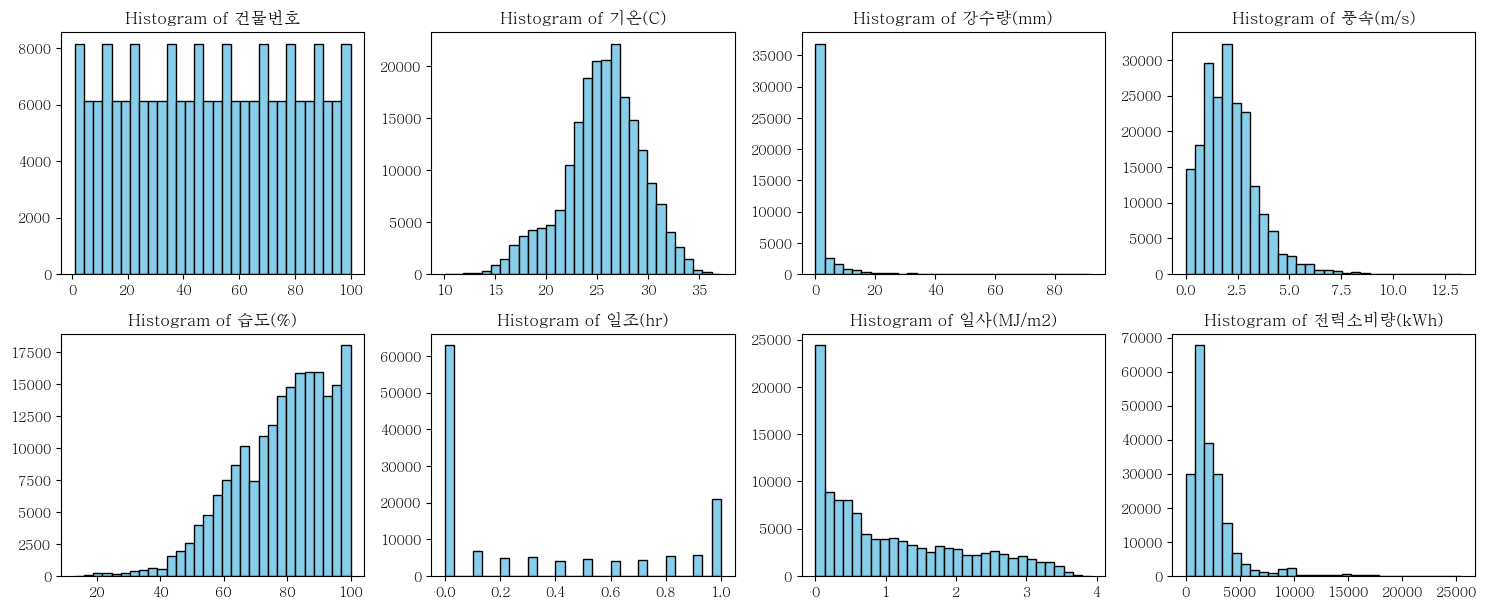

In [73]:
plot_histogram(train_df)